<a href="https://colab.research.google.com/github/kridtapon/KlingerBox-Momentum/blob/main/KlingerBox_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate the Klinger Oscillator
def calculate_klinger_oscillator(df, fast_period=34, slow_period=55):
    """
    Calculate Klinger Oscillator (KO).
    """
    # Calculate the differences between the highs and lows
    diff_high_low = df['High'] - df['Low']
    diff_close_prev_close = df['Close'] - df['Close'].shift(1)

    # Calculate the fast and slow components
    fast_ema = diff_high_low.ewm(span=fast_period).mean()
    slow_ema = diff_high_low.ewm(span=slow_period).mean()

    # Klinger Oscillator
    klinger_oscillator = fast_ema - slow_ema
    return klinger_oscillator

# Function to calculate the Darvas Box levels
def calculate_darvas_box(df, period=20):
    """
    Calculate Darvas Box breakout levels.
    """
    high = df['High'].rolling(window=period).max()
    low = df['Low'].rolling(window=period).min()

    # Upper and lower bounds of the Darvas Box
    return high, low

# Define the stock symbol and time period
symbol = 'META'  # Example stock symbol (Meta)
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Klinger Oscillator (KO)
df['Klinger_Oscillator'] = calculate_klinger_oscillator(df)

# Calculate Darvas Box levels
df['Darvas_Upper'], df['Darvas_Lower'] = calculate_darvas_box(df)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on Klinger Oscillator and Darvas Box
df['Entry'] = (df['Klinger_Oscillator'] > 0) & (df['Close'] < df['Darvas_Upper'])
df['Exit'] = (df['Klinger_Oscillator'] < 0) & (df['Close'] > df['Darvas_Lower'])

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            123496.21892
Total Return [%]                        23.496219
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                       7961.441741
Max Drawdown [%]                        54.453393
Max Drawdown Duration                       785.0
Total Trades                                   38
Total Closed Trades                            37
Total Open Trades                               1
Open Trade PnL                        6606.661299
Win Rate [%]                            51.351351
Best Trade [%]                          22.459791
Worst Trade [%]                        -40.111908
Avg Winning Trade [%]                    6.074068
Avg Losing Trade [%]                    -4.452993


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate the Klinger Oscillator
def calculate_klinger_oscillator(df, fast_period, slow_period):
    diff_high_low = df['High'] - df['Low']
    fast_ema = diff_high_low.ewm(span=fast_period).mean()
    slow_ema = diff_high_low.ewm(span=slow_period).mean()
    return fast_ema - slow_ema

# Function to calculate the Darvas Box levels
def calculate_darvas_box(df, period):
    high = df['High'].rolling(window=period).max()
    low = df['Low'].rolling(window=period).min()
    return high, low

# Define the stock symbol and time period
symbol = 'FICO'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
fast_periods = np.arange(20, 51, 2)   # Fast EMA range
slow_periods = np.arange(50, 81, 2)   # Slow EMA range
darvas_periods = np.arange(10, 31, 2) # Darvas Box window

# Create an optimization grid using itertools.product
param_combinations = itertools.product(fast_periods, slow_periods, darvas_periods)

# Store results
results = []

for fast, slow, darvas in param_combinations:
    if fast >= slow:  # Ensure fast_period < slow_period
        continue

    # Calculate indicators
    df['Klinger_Oscillator'] = calculate_klinger_oscillator(df, fast, slow)
    df['Darvas_Upper'], df['Darvas_Lower'] = calculate_darvas_box(df, darvas)

    # Define Entry and Exit signals
    df['Entry'] = (df['Klinger_Oscillator'] > 0) & (df['Close'] < df['Darvas_Upper'])
    df['Exit'] = (df['Klinger_Oscillator'] < 0) & (df['Close'] > df['Darvas_Lower'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=df['Entry'],
        exits=df['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store results
    results.append({
        "fast_period": fast,
        "slow_period": slow,
        "darvas_period": darvas,
        "total_return": portfolio.total_return()
    })

# Convert results to DataFrame and find the best parameters
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by="total_return", ascending=False).iloc[0]

print("Best Parameters Found:")
print(best_params)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Best Parameters Found:
fast_period      45.000000
slow_period      75.000000
darvas_period    20.000000
total_return      0.704955
Name: 142, dtype: float64


Streaming output truncated to the last 5000 lines.
<ipython-input-19-399c17552209>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-399c17552209>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-399c17552209>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Best Parameters Found:
fast_period      22.000000
slow_period      62.000000
darvas_period    26.000000
total_return      5.382568
Name: 250, dtype: float64


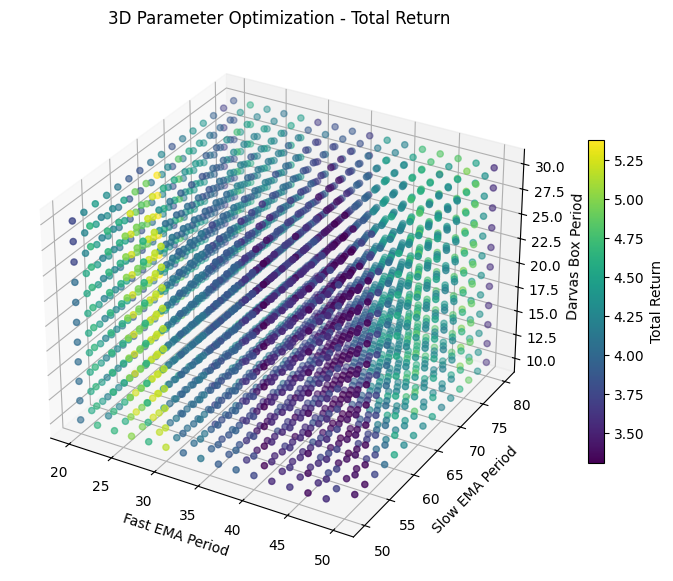

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate the Klinger Oscillator
def calculate_klinger_oscillator(df, fast_period, slow_period):
    diff_high_low = df['High'] - df['Low']
    fast_ema = diff_high_low.ewm(span=fast_period).mean()
    slow_ema = diff_high_low.ewm(span=slow_period).mean()
    return fast_ema - slow_ema

# Function to calculate the Darvas Box levels
def calculate_darvas_box(df, period):
    high = df['High'].rolling(window=period).max()
    low = df['Low'].rolling(window=period).min()
    return high, low

# Define the stock symbol and time period
symbol = 'TPL'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
fast_periods = np.arange(20, 51, 2)   # Fast EMA range
slow_periods = np.arange(50, 81, 2)   # Slow EMA range
darvas_periods = np.arange(10, 31, 2) # Darvas Box window

# Create an optimization grid using itertools.product
param_combinations = itertools.product(fast_periods, slow_periods, darvas_periods)

# Store results
results = []

for fast, slow, darvas in param_combinations:
    if fast >= slow:  # Ensure fast_period < slow_period
        continue

    # Calculate indicators
    df['Klinger_Oscillator'] = calculate_klinger_oscillator(df, fast, slow)
    df['Darvas_Upper'], df['Darvas_Lower'] = calculate_darvas_box(df, darvas)

    # Filter data for the test period (2020-2025)
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Define Entry and Exit signals
    df_filter['Entry'] = (df_filter['Klinger_Oscillator'] > 0) & (df_filter['Close'] < df_filter['Darvas_Upper'])
    df_filter['Exit'] = (df_filter['Klinger_Oscillator'] < 0) & (df_filter['Close'] > df_filter['Darvas_Lower'])

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store results
    results.append({
        "fast_period": fast,
        "slow_period": slow,
        "darvas_period": darvas,
        "total_return": portfolio.total_return()
    })

# Convert results to DataFrame and find the best parameters
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by="total_return", ascending=False).iloc[0]

print("Best Parameters Found:")
print(best_params)

# 3D Plot of Optimization Results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(
    results_df["fast_period"],
    results_df["slow_period"],
    results_df["darvas_period"],
    c=results_df["total_return"],
    cmap='viridis',
    marker='o'
)

# Labels and title
ax.set_xlabel("Fast EMA Period")
ax.set_ylabel("Slow EMA Period")
ax.set_zlabel("Darvas Box Period")
ax.set_title("3D Parameter Optimization - Total Return")

# Color bar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Total Return")

plt.show()

In [ ]:
# Calculate Klinger Oscillator (KO)
df['Klinger_Oscillator'] = calculate_klinger_oscillator(df, 22, 62)

# Calculate Darvas Box levels
df['Darvas_Upper'], df['Darvas_Lower'] = calculate_darvas_box(df, 26)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on Klinger Oscillator and Darvas Box
df['Entry'] = (df['Klinger_Oscillator'] > 0) & (df['Close'] < df['Darvas_Upper'])
df['Exit'] = (df['Klinger_Oscillator'] < 0) & (df['Close'] > df['Darvas_Lower'])

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

<ipython-input-20-4e8b984664e8>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-4e8b984664e8>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/s

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           638256.799618
Total Return [%]                         538.2568
Benchmark Return [%]                   370.656071
Max Gross Exposure [%]                      100.0
Total Fees Paid                      22664.010741
Max Drawdown [%]                        57.579975
Max Drawdown Duration                       350.0
Total Trades                                   37
Total Closed Trades                            36
Total Open Trades                               1
Open Trade PnL                      -27510.139362
Win Rate [%]                            66.666667
Best Trade [%]                         112.745992
Worst Trade [%]                        -26.628907
Avg Winning Trade [%]                   12.853188
Avg Losing Trade [%]                    -5.112383
